In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp


def gaussian_mixture_model(mu=-5.0, sigma=5.0, gamma=20.0):
    def sample_fn(rng_key, num_samples):
        key1, key2, key3 = jax.random.split(rng_key, 3)
        prob_mixture = jax.random.bernoulli(key1, p=0.5, shape=(num_samples, 1))
        mixture_1 = jax.random.normal(key2, shape=(num_samples, 1)) * sigma + mu
        mixture_2 = jax.random.normal(key3, shape=(num_samples, 1)) * sigma + gamma - mu
        return prob_mixture * mixture_1 + (1 - prob_mixture) * mixture_2

    def logprior_fn(position):
        return 0

    def loglikelihood_fn(position, x):
        mixture_1 = jax.scipy.stats.norm.logpdf(x, loc=position, scale=sigma)
        mixture_2 = jax.scipy.stats.norm.logpdf(x, loc=-position + gamma, scale=sigma)
        return jsp.special.logsumexp(jnp.array([mixture_1, mixture_2])) + jnp.log(0.5)

    return sample_fn, logprior_fn, loglikelihood_fn


sample_fn, logprior_fn, loglikelihood_fn = gaussian_mixture_model()

In [2]:
data_size = 1000

rng_key = jax.random.PRNGKey(888)
rng_key, sample_key = jax.random.split(rng_key)
X_data = sample_fn(sample_key, data_size)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'Data')

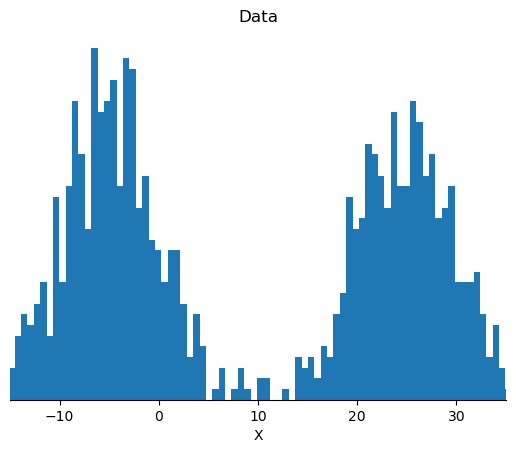

In [3]:
import matplotlib.pylab as plt

ax = plt.subplot(111)
ax.hist(X_data.squeeze(), 100)
ax.set_xlabel("X")
ax.set_xlim(left=-15, right=35)

ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.title("Data")

In [12]:
from fastprogress import progress_bar

import blackjax
import blackjax.sgmcmc.gradients as gradients


# Specify hyperparameters for SGLD
total_iter = 10_000
thinning_factor = 10

batch_size = 100
lr = 1e-3
temperature = 50.0

init_position = 10.0


# Build the SGDL sampler
grad_fn = gradients.grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.sgld(grad_fn)


# Initialize and take one step using the vanilla SGLD algorithm
position = init_position
sgld_sample_list = jnp.array([])

pb = progress_bar(range(total_iter))
for iter_ in pb:
    rng_key, batch_key, sample_key = jax.random.split(rng_key, 3)
    data_batch = jax.random.shuffle(batch_key, X_data)[:batch_size, :]
    position = jax.jit(sgld)(sample_key, position, data_batch, lr, temperature)
    if iter_ % thinning_factor == 0:
        sgld_sample_list = jnp.append(sgld_sample_list, position)
        pb.comment = f"| position: {position: .2f}"

TypeError: Expected a callable value, got SamplingAlgorithm(init=<function sgld.__new__.<locals>.init_fn at 0x7f5114afe840>, step=<function sgld.__new__.<locals>.step_fn at 0x7f5114aff1a0>)

Text(0.5, 0.98, 'Stochastic gradient Langevin dynamics (SGLD)')

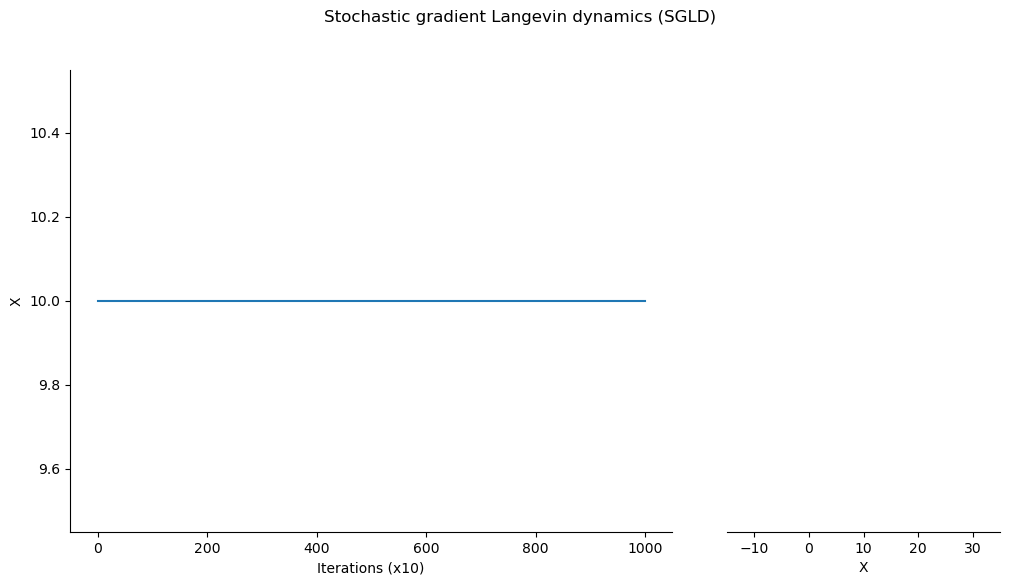

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 6))

G = gridspec.GridSpec(1, 3)

# Trajectory
ax = plt.subplot(G[0, :2])
ax.plot(sgld_sample_list, label="SGLD")
ax.set_xlabel(f"Iterations (x{thinning_factor})")
ax.set_ylabel("X")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


# Histogram
ax = plt.subplot(G[0, 2])
ax.hist(sgld_sample_list, 100)
ax.set_xlabel("X")
ax.set_xlim(left=-15, right=35)

ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)


plt.suptitle("Stochastic gradient Langevin dynamics (SGLD)")

In [17]:
from fastprogress import progress_bar

import blackjax
import blackjax.sgmcmc.gradients as gradients

from functools import partial
from jax import random, jit

# Specify hyperparameters for SGLD
total_iter = 10_000
thinning_factor = 10

batch_size = 100
lr = 1e-3
temperature = 50.0

init_position = 10.0


# Build the SGDL sampler
grad_fn = gradients.grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.sgld(grad_fn)

# Initialize and take one step using the vanilla SGLD algorithm
position = init_position
sgld_sample_list = jnp.array([])

pb = progress_bar(range(total_iter))
for iter_ in pb:
    rng_key, batch_key, sample_key = jax.random.split(rng_key, 3)
    data_batch = jax.random.shuffle(batch_key, X_data)[:batch_size, :]
    #sgld = partial(jit, static_argnums=(1,))(sgld)
    position = sgld(sample_key, position, data_batch, lr, temperature)
    if iter_ % thinning_factor == 0:
        sgld_sample_list = jnp.append(sgld_sample_list, position)
        pb.comment = f"| position: {position: .2f}"

TypeError: 'SamplingAlgorithm' object is not callable